# Topic Analysis - Grid search for optimal parameters for LDA

We'll run a grid-search on the hyperparameters `alpha` (determine the sparsity of the topic distributions for documents) and `beta` (determine the sparsity of the word distribution for topics) and `num_topics` parameters of the LDA model and pick the model with the lowest [perplexity](https://en.wikipedia.org/wiki/Perplexity). We'll use the bag-of-words representation from the notebook `01_(a)_topic_modeling.ipynb` to grid search on [MADlib's LDA](http://doc.madlib.net/latest/group__grp__lda.html) model.

## Setup database connectivity

We'll reuse our module from the previous notebook (***`00_database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [11]:
%run '00_database_connectivity_setup.ipynb'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from IPython.display import Image
from wordcloud import WordCloud
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

### 1. Perform grid-search on LDA

In [7]:
sql = '''
    drop function if exists YOUR_SCHEMA.lda_gridsearch(
        alphas float8[], 
        betas float8[], 
        num_topics_arr int[],
        input_table text,
        mdl_table text,
        output_table text
    );
    create or replace function YOUR_SCHEMA.lda_gridsearch(
        alphas float8[],
        betas float8[],
        num_topics_arr int[],
        input_table text,
        mdl_table text,
        output_table text
    )
    returns text
    as
    $$
        import plpy
        from itertools import product
        #Get vocabulary size
        voc_size = plpy.execute(
            """
                select 
                    count(distinct wordid) as voc_size 
                from 
                    {input_table}
            """.format(
                input_table=input_table
            )
        )[0]['voc_size']
        
        mdl = """
            drop table if exists {mdl_table} cascade;
            drop table if exists {mdl_table}_results cascade;
            select 
                madlib.lda_train(
                    '{input_table}', -- data_table',
                    '{mdl_table}', -- model_table',
                    '{mdl_table}_results', -- output_data_table',
                    {voc_size}, -- voc_size,
                    {num_topics}, -- topic_num,
                    50, -- iter_num,
                    {alpha}, -- alpha (recommended = 50/topic_num),
                    {beta} -- beta
                );
        """
        first_step = True
        iter = 0
        for alpha, beta, num_topics in product(alphas, betas, num_topics_arr):
            plpy.info('Iteration {0} of {1}'.format(iter, len(list(product(alphas, betas, num_topics_arr)))))
            plpy.info('alpha:{0}, beta:{1}, num_topics: {2}'.format(alpha, beta, num_topics))
            plpy.execute(
                mdl.format(
                    voc_size=voc_size,
                    alpha=alpha,
                    beta=beta,
                    num_topics=num_topics,
                    input_table=input_table,
                    mdl_table=mdl_table
                )
            )
            if(first_step):
                output_tbl_ctas_sql = """
                    drop table if exists {output_table};
                    create table {output_table}
                    as
                    (
                        select 
                            t1.*,
                            t2.*
                        from
                            {mdl_table} t1,
                            --Perplexity
                            (
                                select
                                    madlib.lda_get_perplexity(
                                        '{mdl_table}',
                                        '{mdl_table}_results'
                                    )
                                
                            ) t2
                    ) distributed randomly;
                """
                plpy.execute(
                    output_tbl_ctas_sql.format(
                        output_table=output_table,
                        mdl_table=mdl_table
                    )
                )
                first_step = False
            else:
                output_tbl_insert_sql = """
                    insert into {output_table}
                    select 
                        t1.*,
                        t2.*
                    from
                        {mdl_table} t1,
                        --Perplexity
                        (
                            select
                                madlib.lda_get_perplexity(
                                    '{mdl_table}',
                                    '{mdl_table}_results'
                                )

                        ) t2
                """
                plpy.execute(
                    output_tbl_insert_sql.format(
                        output_table=output_table,
                        mdl_table=mdl_table
                    )
                )
                
            iter += 1
        return 'Grid search results written to {output_table}'.format(output_table=output_table)  
    $$language plpythonu;
'''
psql.execute(sql, conn)
conn.commit()

In [8]:
#Invoke the grid-search
sql = """
    select
        YOUR_SCHEMA.lda_gridsearch(
            ARRAY[0.05, 0.10, 0.20], --alphas (smaller the value, sparser the distribution
            ARRAY[0.05, 0.10, 0.20], --betas (smaller the value, sparser the distribution
            ARRAY[60, 40, 20], -- num_topics array,
            'YOUR_SCHEMA.twenty_news_groups_lda_input', -- LDA input table
            'YOUR_SCHEMA.twenty_news_groups_lda_mdl', -- LDA model table
            'YOUR_SCHEMA.twenty_news_groups_lda_gridsearch_results' --output table
        );
"""
result_df = psql.read_sql(sql, conn)
display(result_df)
conn.commit()

,lda_gridsearch
0,Grid search results written to YOUR_SCHEMA.twenty_news_groups_lda_gridsearch_results


### 2. Show the results of grid-search

In [12]:
sql = """
    select
        topic_num,
        alpha,
        beta,
        lda_get_perplexity as perplexity
    from
        YOUR_SCHEMA.twenty_news_groups_lda_gridsearch_results
    order by lda_get_perplexity
"""
df = psql.read_sql(sql, conn)
display(df)

,topic_num,alpha,beta,perplexity
0,60,0.05,0.05,1713.711675
1,60,0.10,0.05,1736.610864
2,60,0.10,0.10,1746.921215
3,60,0.05,0.10,1748.835919
4,60,0.20,0.05,1757.693713
5,60,0.20,0.10,1762.647346
6,60,0.05,0.20,1797.798806
7,60,0.10,0.20,1806.642433
8,60,0.20,0.20,1816.881231
9,40,0.10,0.05,1893.983316


#### Plot perplexity as a function of alpha, beta for a given value of num_topics

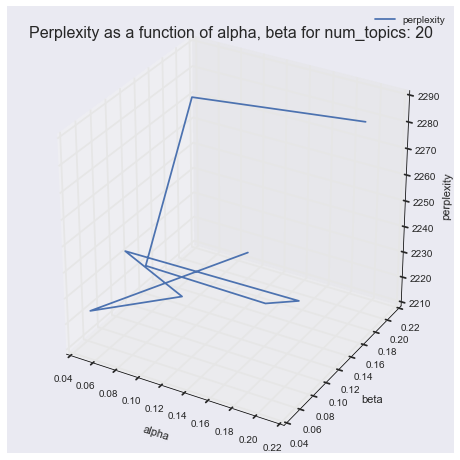

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = fig.gca(projection='3d')
df_slice = df[df.topic_num==20]
ax.plot(df_slice['alpha'].tolist(), df_slice['beta'].tolist(), df_slice['perplexity'].tolist(), label='perplexity')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('perplexity')
ax.legend()
plt.title('Perplexity as a function of alpha, beta for num_topics: {0}'.format(20), fontsize=16)
plt.show()

#### Plot perplexity as a function of num_topics, for a given value of (alpha, beta)

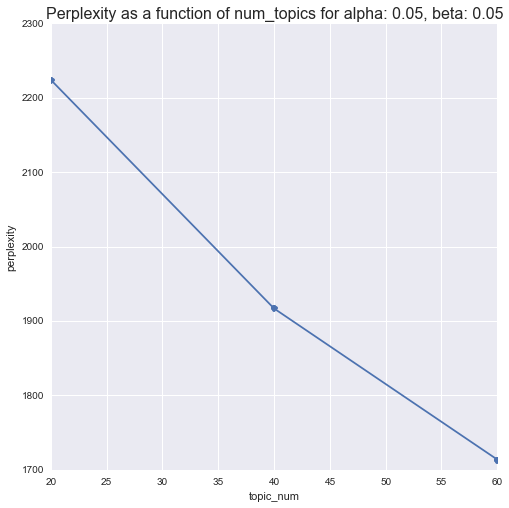

In [15]:
sample_alpha, sample_beta = 0.05, 0.05
plt.figure(figsize=(8,8))
df_slice = df[(df.alpha==sample_alpha) & (df.beta==sample_beta)]
plt.plot(df_slice['topic_num'].tolist(), df_slice['perplexity'].tolist(), marker='o', label='perplexity')
plt.xlabel('topic_num')
plt.ylabel('perplexity')
plt.title('Perplexity as a function of num_topics for alpha: {0}, beta: {1}'.format(sample_alpha, sample_beta), fontsize=16)
plt.show()

From the figure above, we gather that as we increase the number of topics, the reduction in perplexity becomes smaller and smaller at a rapid rate.

### Optimal parameters summary

Based on the above plots, we choose `num_topics=60` and `alpha=0.05`, `beta=0.05` as the optimal parameters of the LDA

In [16]:
sql = """
    select
        topic_num,
        alpha,
        beta,
        lda_get_perplexity as perplexity
    from
        YOUR_SCHEMA.twenty_news_groups_lda_gridsearch_results
    where
        topic_num = 60
    order by lda_get_perplexity
"""
df = psql.read_sql(sql, conn)
display(df)

,topic_num,alpha,beta,perplexity
0,60,0.05,0.05,1713.711675
1,60,0.10,0.05,1736.610864
2,60,0.10,0.10,1746.921215
3,60,0.05,0.10,1748.835919
4,60,0.20,0.05,1757.693713
5,60,0.20,0.10,1762.647346
6,60,0.05,0.20,1797.798806
7,60,0.10,0.20,1806.642433
8,60,0.20,0.20,1816.881231
